In [1]:
from MPPI.mppi import MPPI, MPPILogger
from MPPI.mppi_ddp import MPPIDDP

import numpy as np
import pinocchio as pin
import crocoddyl
import example_robot_data as robex
import matplotlib.pyplot as plt 
from utils.plotting import plot_control_sequence, plot_state_trajectory, plot_cost, plot_convergence


from schaeffler2025.meshcat_viewer_wrapper import MeshcatVisualizer


In [2]:
# First, let's load the Pinocchio model for the Panda arm.

robot = robex.load('panda')
# The 2 last joints are for the fingers, not important in arm motion, freeze them
robot.model,[robot.visual_model,robot.collision_model] = \
    pin.buildReducedModel(robot.model,[robot.visual_model,robot.collision_model],[8,9],robot.q0)
robot.q0 = robot.q0[:7].copy()

HORIZON_LENGTH = 100
TIME_STEP = 1e-2
FRAME_TIP = robot.model.getFrameId("panda_hand_tcp")
GOAL_POSITION = np.array([.2,0.6,.5])
GOAL_PLACEMENT = pin.SE3(pin.utils.rpyToMatrix(-np.pi,-1.5,1.5), GOAL_POSITION)
REACH_DIMENSION = "3d" # "6d"

robot_model = robot.model
robot_model.armature = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.])*5
robot_model.q0 = np.array([3.5,2,2,0,0,0,0])
robot_model.x0 = np.concatenate([robot_model.q0, np.zeros(robot_model.nv)])
robot_model.gravity *= 0

In [3]:
viz = MeshcatVisualizer(robot)
viz.display(robot.q0)
viz.addBox("world/goal", [0.1, 0.1, 0.1], [0, 1, 0, 1])
viz.applyConfiguration("world/goal", GOAL_PLACEMENT)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7008/static/


In [4]:
viz.viewer.jupyter_cell()

In [5]:
# Again???

robot_model = robot.model
robot_model.armature = np.ones(robot.model.nv)*2 # Arbitrary value representing the true armature
robot_model.q0 = robot.q0.copy()
robot_model.x0 = np.concatenate([robot_model.q0, np.zeros(robot_model.nv)])

In [6]:
state = crocoddyl.StateMultibody(robot_model)
runningCostModel = crocoddyl.CostModelSum(state)
terminalCostModel = crocoddyl.CostModelSum(state)

# %load tp8/generated/panda_reaches_a_single_target_cost_goal
if REACH_DIMENSION == "3d":
    # Cost for 3d tracking || p(q) - pref ||**2
    goalTrackingRes = crocoddyl.ResidualModelFrameTranslation(state,FRAME_TIP,GOAL_POSITION)
    goalTrackingWeights = crocoddyl.ActivationModelWeightedQuad(np.array([1,1,1]))
elif REACH_DIMENSION == "6d":
    # Cost for 6d tracking  || log( M(q)^-1 Mref ) ||**2
    goalTrackingRes = crocoddyl.ResidualModelFramePlacement(state,FRAME_TIP,GOAL_PLACEMENT)
    goalTrackingWeights = crocoddyl.ActivationModelWeightedQuad(np.array([1,1,1, 1,1,1]))
else:
    assert( REACH_DIMENSION=="3d" or REACH_DIMENSION=="6d" )

goalTrackingCost = crocoddyl.CostModelResidual(state,goalTrackingWeights,goalTrackingRes)
runningCostModel.addCost("gripperPose", goalTrackingCost, .001)
terminalCostModel.addCost("gripperPose", goalTrackingCost, 4)

# Cost for state regularization || x - x* ||**2
# We set up different values for the integral cost and terminal cost term.

# Regularization is stronger on position than velocity (to account for typical unit scale)
xRegWeights = crocoddyl.ActivationModelWeightedQuad(np.array([1,1,1,1,1,1,1, .1,.1,.1,.1,.1,.1,.1]))
xRegRes = crocoddyl.ResidualModelState(state,robot_model.x0)
xRegCost = crocoddyl.CostModelResidual(state,xRegWeights,xRegRes)
runningCostModel.addCost("xReg", xRegCost, 1e-3)

# Terminal cost for state regularization || x - x* ||**2
# Require more strictly a small velocity at task end (but we don't car for the position)
xRegWeightsT=crocoddyl.ActivationModelWeightedQuad(np.array([.5,.5,.5,.5,.5,.5,.5,  5.,5.,5.,5.,5.,5.,5.]))
xRegResT = crocoddyl.ResidualModelState(state,robot_model.x0)
xRegCostT = crocoddyl.CostModelResidual(state,xRegWeightsT,xRegResT)
terminalCostModel.addCost("xReg", xRegCostT, .01)

# Cost for control regularization || u - g(q) ||**2
uRegRes = crocoddyl.ResidualModelControlGrav(state)
uRegCost = crocoddyl.CostModelResidual(state,uRegRes)
runningCostModel.addCost("uReg", uRegCost, 1e-6)

In [7]:
# Next, we need to create the running and terminal action model.
# The forward dynamics (computed using ABA) are implemented
# inside DifferentialActionModelFullyActuated.

# The actuation model is here trivial: tau_q = u.
actuationModel = crocoddyl.ActuationModelFull(state)
# Running model composing the costs, the differential equations of motion and the integrator.
runningModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, runningCostModel), TIME_STEP)
runningModel.differential.armature = robot_model.armature
# Terminal model following the same logic, although the integration is here trivial.
terminalModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, terminalCostModel), 0.)
terminalModel.differential.armature = robot_model.armature


In [8]:
problem = crocoddyl.ShootingProblem(robot_model.x0, [runningModel] * HORIZON_LENGTH, terminalModel)


## Solving the OCP with DDP

In [9]:
data = runningModel.createData()

In [10]:
# problem = crocoddyl.ShootingProblem(x0, [ model ] * T, model_term)
# problem.terminalModel = model_term
u_nom = np.zeros((HORIZON_LENGTH, 7))

mppi_solver_check = MPPI(runningModel, terminalModel, HORIZON_LENGTH, 1, 1, np.full(7, 0.1))
x_nom, _ = mppi_solver_check.rollout_trajectory(robot_model.x0, u_nom)

ddp = crocoddyl.SolverDDP(problem)
ddp.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose()])
conv = ddp.solve(init_us=list(u_nom), init_xs=list(x_nom), maxiter=30)


iter    cost       merit      stop      |grad|      preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  4.181e-01  0.000e+00  7.386e-01  1.477e+00  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  7.386e-01  3.253e-01  0.000e+00  0.000e+00
   1  2.685e-01  0.000e+00  4.153e-01  8.306e-01  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  4.153e-01  1.495e-01  0.000e+00  0.000e+00
   2  3.920e-02  0.000e+00  2.650e-01  5.301e-01  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  2.650e-01  2.293e-01  0.000e+00  0.000e+00
   3  6.755e-03  0.000e+00  3.364e-02  6.729e-02  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  3.364e-02  3.244e-02  0.000e+00  0.000e+00
   4  5.837e-03  0.000e+00  9.595e-04  1.919e-03  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  9.595e-04  9.178e-04  0.000e+00  0.000e+00
   5  5.780e-03  0.000e+00  6.937e-05  1.387e-04  1.000e-09  1.000e

/home/tsreckovic/Code/ddp-vs-mppi/utils/plotting.py:124: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend() # Add legend if it's a standalone plot


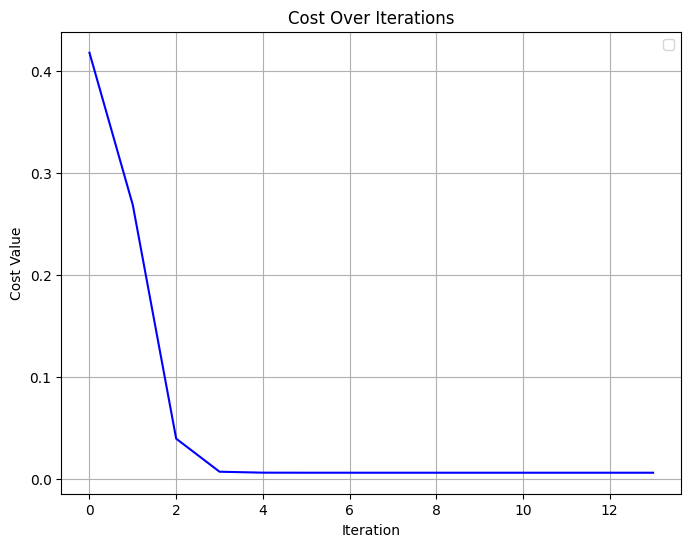

<Axes: title={'center': 'Cost Over Iterations'}, xlabel='Iteration', ylabel='Cost Value'>

In [20]:
log = ddp.getCallbacks()[0]
u_opt_ddp = np.array(log.us)
# plot_control_sequence(u_opt_ddp)

x_opt_ddp = np.array(log.xs)
ddp_costs = log.costs
# plot_state_trajectory(x_opt_ddp)

plot_cost(log.costs)
# plot_convergence(log.costs)

In [14]:
# mppi_solver_check = MPPI(runningModel, terminalModel, HORIZON_LENGTH, 1, 1, np.full(7, 0.1))
# x_opt_check, cost_check = mppi_solver_check.rollout_trajectory(robot_model.x0, u_opt_ddp)

In [21]:
viz.display(robot.q0)
viz.viewer.jupyter_cell()

In [22]:
viz.play([x[:robot.model.nq] for x in ddp.xs], TIME_STEP)

In [18]:
# crocoddyl.plotConvergence(
#     log.costs,
#     log.pregs,
#     log.dregs,
#     log.grads,
#     log.stops,
#     log.steps,
#     figIndex=2,
#     show=False,
# )

## Solving the OCP with MPPI

In [17]:
# MPPI parameters

horizon = HORIZON_LENGTH       # Number of time steps in the prediction horizon
num_samples = 100    # Number of control samples
lambda_param = 100    # Temperature parameter
noise_std = np.full(7, 0.1) # Std dev for [linear_vel_noise, angular_vel_noise]
n_iter = 50
# Logging
logger_mppi = MPPILogger(enable_logging=True, n_log=5)

# Initial state for the unicycle: [x, y, yaw]
x0 = robot_model.x0

print("Running MPPI solver...")
mppi_solver = MPPI(runningModel, terminalModel, horizon, num_samples, lambda_param, noise_std, param_gamma=0.01,
                   param_exploration=0.0, n_filt=1, logger=logger_mppi)
u_opt_mppi = mppi_solver.solve(x0, num_iterations=n_iter)

print("\nRolling out trajectory with optimal controls...")
x_opt_mppi, mppi_final_cost = mppi_solver.rollout_trajectory(x0, u_opt_mppi)
# Store the final optimized nominal control sequence in the logger
logger_mppi.set_final_controls(u_opt_mppi)
logger_mppi.set_final_state(x_opt_mppi)

print(f"Final cost of optimal trajectory: {mppi_final_cost:.4f}")

Running MPPI solver...
Iteration 1/50, Min Cost: 0.7399, Mean Cost: 0.7434
Iteration 2/50, Min Cost: 0.7579, Mean Cost: 0.8077
Iteration 3/50, Min Cost: 0.7766, Mean Cost: 0.8729
Iteration 4/50, Min Cost: 0.8464, Mean Cost: 0.9505
Iteration 5/50, Min Cost: 0.8517, Mean Cost: 1.0264
Iteration 6/50, Min Cost: 0.9461, Mean Cost: 1.0879
Iteration 7/50, Min Cost: 1.0098, Mean Cost: 1.1478
Iteration 8/50, Min Cost: 1.0622, Mean Cost: 1.2173
Iteration 9/50, Min Cost: 1.1075, Mean Cost: 1.3052
Iteration 10/50, Min Cost: 1.1591, Mean Cost: 1.3792
Iteration 11/50, Min Cost: 1.2689, Mean Cost: 1.4564
Iteration 12/50, Min Cost: 1.3047, Mean Cost: 1.5138
Iteration 13/50, Min Cost: 1.3209, Mean Cost: 1.5598
Iteration 14/50, Min Cost: 1.3953, Mean Cost: 1.6344
Iteration 15/50, Min Cost: 1.4628, Mean Cost: 1.7256
Iteration 16/50, Min Cost: 1.5358, Mean Cost: 1.7928
Iteration 17/50, Min Cost: 1.5400, Mean Cost: 1.8571
Iteration 18/50, Min Cost: 1.6041, Mean Cost: 1.9176
Iteration 19/50, Min Cost: 1.626

<Axes: title={'center': 'Cost Over Iterations'}, xlabel='Iteration', ylabel='Cost Value'>

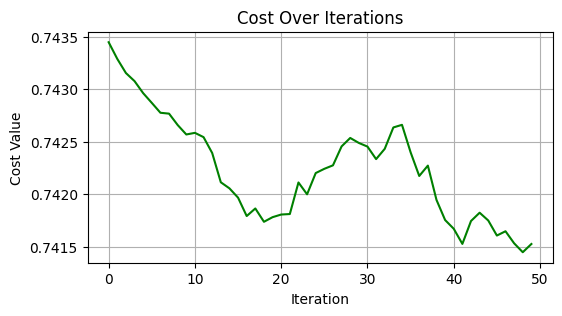

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3)) # [2]

# Plot each cost history on the same subplot
plot_cost(logger_mppi.total_cost_hist, ax=ax, color="green",  label="MPPI") 

In [24]:
viz.display(robot.q0)
viz.viewer.jupyter_cell()

In [29]:
# viz.viewer.jupyter_cell()
viz.play([x[:robot.model.nq] for x in x_opt_mppi], TIME_STEP)

## Plots

array([<Axes: title={'center': 'State Trajectory'}>, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: xlabel='Time Step (Horizon + 1)'>], dtype=object)

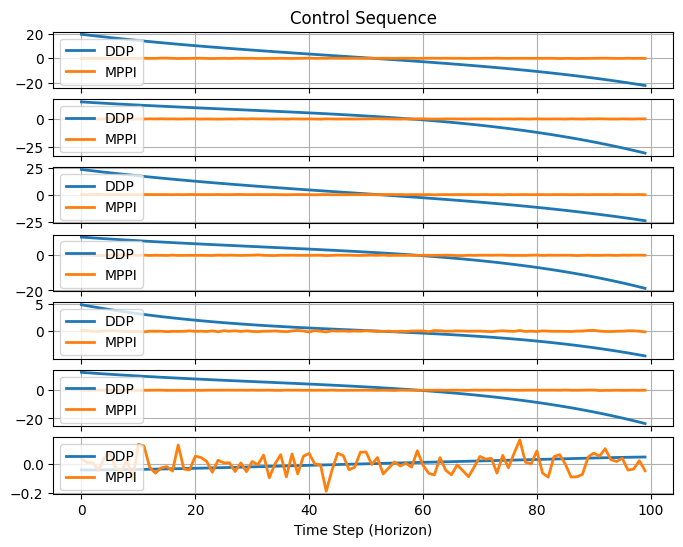

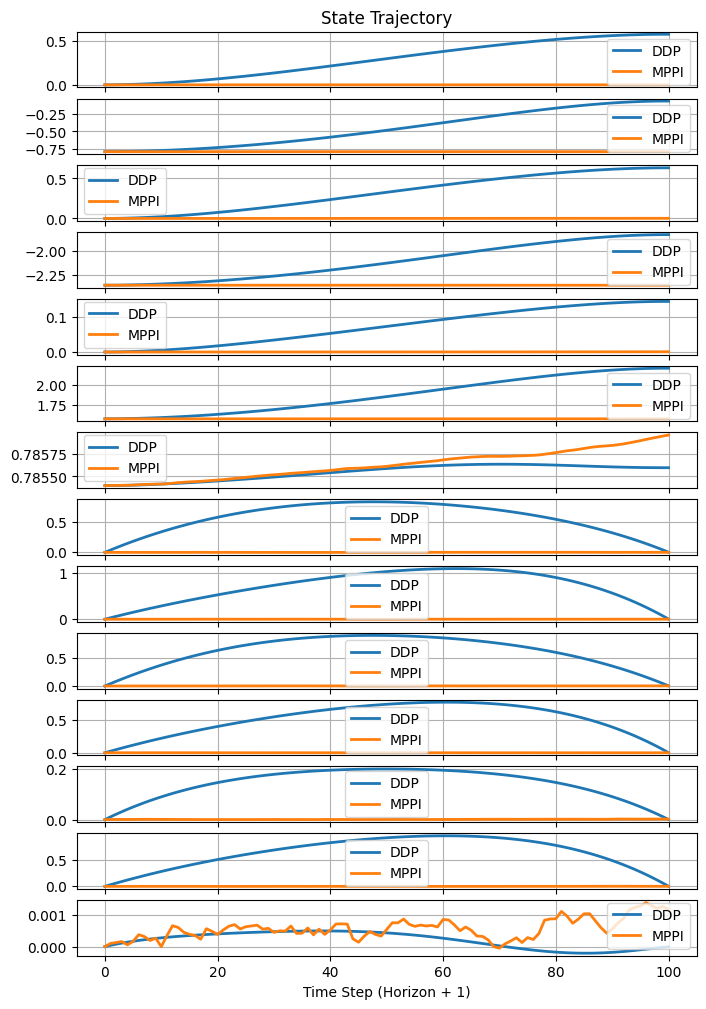

In [30]:
nu = 7
nx =14

fig, axs = plt.subplots(nu, 1, figsize=(8, 6))
plot_control_sequence(u_opt_ddp, axs, labels=["DDP"]*nu)
plot_control_sequence(u_opt_mppi, axs, labels=["MPPI"]*nu)

fig, axs = plt.subplots(nx, 1, figsize=(8, 12))
plot_state_trajectory(x_opt_ddp, axs, labels=["DDP"]*nx)
plot_state_trajectory(x_opt_mppi, axs, labels=["MPPI"]*nx)

## Solving OCP with MPPI-DDP

In [31]:
# MPPI parameters
horizon = HORIZON_LENGTH       # Number of time steps in the prediction horizon
num_samples = 100    # Number of control samples
lambda_param = 100   # Temperature parameter
noise_std = np.full(7, 1) # Std dev for [linear_vel_noise, angular_vel_noise]
n_iter = 200

# Logging
logger_mppi_ddp = MPPILogger(enable_logging=True, n_log=5)

# Initial state for the unicycle: [x, y, yaw]
x0 = robot_model.x0

print("Running MPPI-DDP solver...")
# FIX: Add 'problem' as the ddp_problem argument
mppi_ddp_solver = MPPIDDP(runningModel, terminalModel, horizon, num_samples, lambda_param, noise_std,
                      ddp_problem=problem,
                      param_exploration=0.0, n_filt=1, logger=logger_mppi_ddp,
                      num_ddp_replace=1)
u_opt_mppi_ddp = mppi_ddp_solver.solve(x0, num_iterations=n_iter)

print("\nRolling out trajectory with optimal controls...")
x_opt_mppi_ddp, final_cost_mppi_ddp = mppi_ddp_solver.rollout_trajectory(x0, u_opt_mppi_ddp)
# Store the final optimized nominal control sequence in the logger
logger_mppi_ddp.set_final_controls(u_opt_mppi_ddp)
logger_mppi_ddp.set_final_state(x_opt_mppi_ddp)

print(f"Final cost of optimal trajectory: {final_cost_mppi_ddp:.4f}")

Running MPPI-DDP solver...
Iteration 1/200, Min Cost: 0.4181, Mean Cost: 0.7398, DDP Cost: 0.4181, DDP converged: False
Iteration 2/200, Min Cost: 0.4113, Mean Cost: 0.7257, DDP Cost: 0.4113, DDP converged: False
Iteration 3/200, Min Cost: 0.4034, Mean Cost: 0.7118, DDP Cost: 0.4034, DDP converged: False
Iteration 4/200, Min Cost: 0.3968, Mean Cost: 0.6979, DDP Cost: 0.3968, DDP converged: False
Iteration 5/200, Min Cost: 0.3890, Mean Cost: 0.6848, DDP Cost: 0.3890, DDP converged: False
Iteration 6/200, Min Cost: 0.3815, Mean Cost: 0.6725, DDP Cost: 0.3815, DDP converged: False
Iteration 7/200, Min Cost: 0.3758, Mean Cost: 0.6589, DDP Cost: 0.3758, DDP converged: False
Iteration 8/200, Min Cost: 0.3685, Mean Cost: 0.6457, DDP Cost: 0.3685, DDP converged: False
Iteration 9/200, Min Cost: 0.3613, Mean Cost: 0.6344, DDP Cost: 0.3613, DDP converged: False
Iteration 10/200, Min Cost: 0.3549, Mean Cost: 0.6215, DDP Cost: 0.3549, DDP converged: False
Iteration 11/200, Min Cost: 0.3484, Mean C

In [32]:
viz.display(robot.q0)
viz.viewer.jupyter_cell()

In [33]:
viz.play([x[:robot.model.nq] for x in x_opt_mppi_ddp], TIME_STEP)

array([<Axes: title={'center': 'State Trajectory'}>, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: xlabel='Time Step (Horizon + 1)'>], dtype=object)

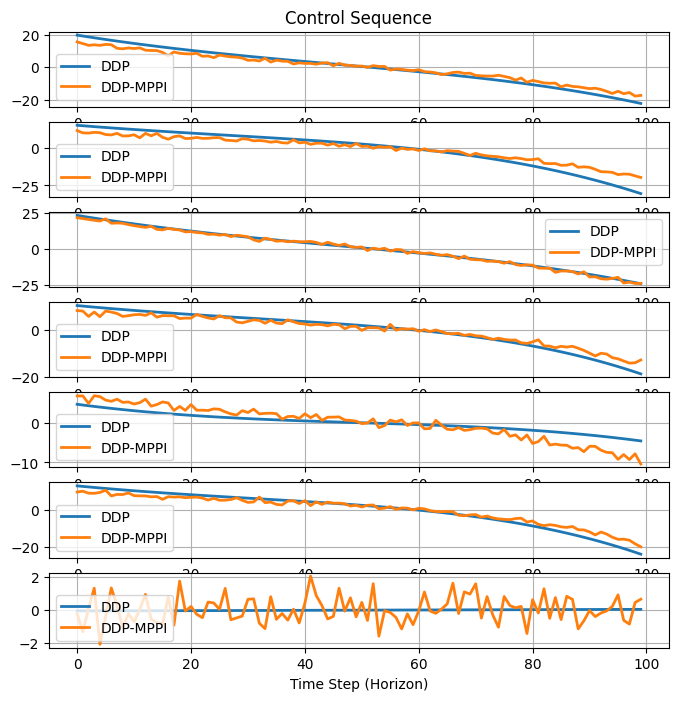

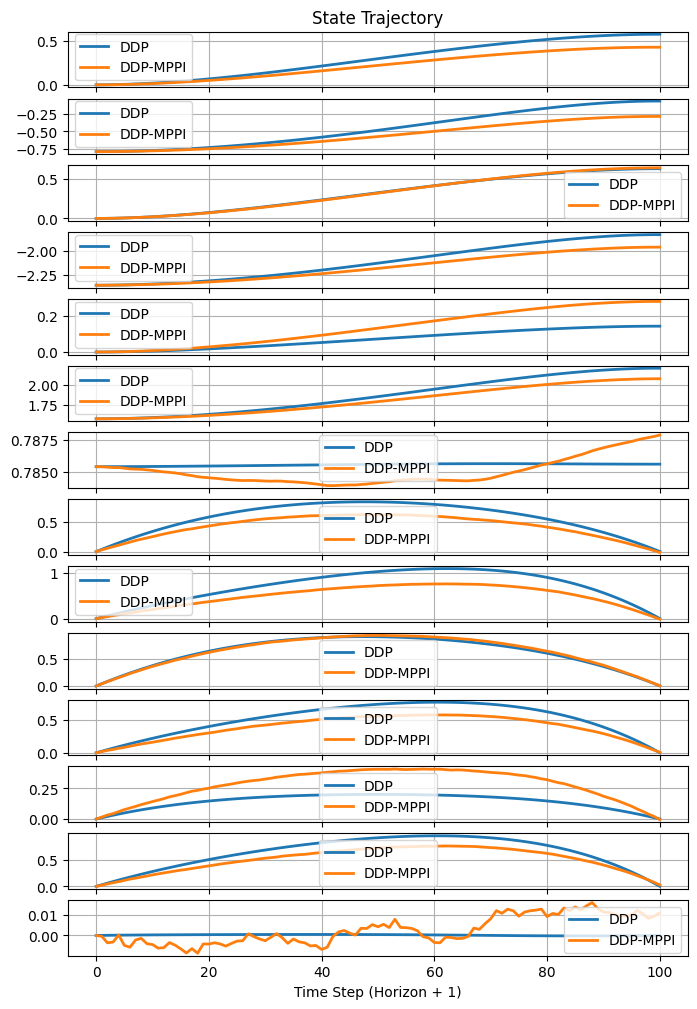

In [34]:
nu = 7
nx =14

fig, axs = plt.subplots(nu, 1, figsize=(8, 8))
plot_control_sequence(u_opt_ddp, axs, labels=["DDP"]*nu)
#plot_control_sequence(u_opt_mppi, axs, labels=["MPPI"]*nu)
plot_control_sequence(u_opt_mppi_ddp, axs, labels=["DDP-MPPI"]*nu) # Added DDP-MPPI control sequence


fig, axs = plt.subplots(nx, 1, figsize=(8, 12))
plot_state_trajectory(x_opt_ddp, axs, labels=["DDP"]*nx)
#plot_state_trajectory(x_opt_mppi, axs, labels=["MPPI"]*nx)
plot_state_trajectory(x_opt_mppi_ddp, axs, labels=["DDP-MPPI"]*nx) # Added DDP-MPPI state trajectory

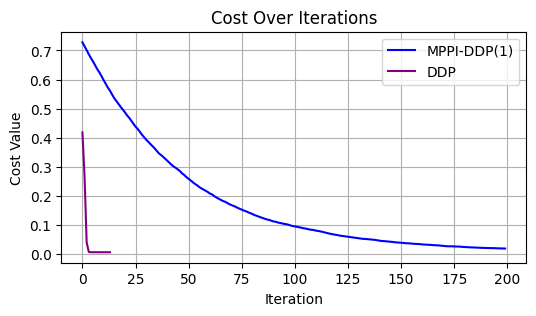

In [35]:
# Create a figure and a single subplot for the cost histories
fig, ax = plt.subplots(1, 1, figsize=(6, 3)) # [2]

# Plot each cost history on the same subplot
# plot_cost(logger_mppi.total_cost_hist, ax=ax, color="green",  label="MPPI") 
plot_cost(logger_mppi_ddp.total_cost_hist, ax=ax, color="blue", label="MPPI-DDP(1)")
plot_cost(ddp_costs, ax=ax, color="purple", label="DDP")
ax.legend()
# ax.set_ylim(10, 50)

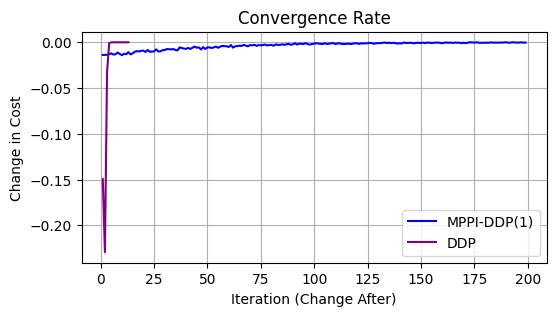

In [36]:
# Create a figure and a single subplot for the cost histories
fig, ax = plt.subplots(1, 1, figsize=(6, 3)) # [2]

# Plot each cost history on the same subplot
# plot_convergence(logger_mppi.total_cost_hist, ax=ax, color="green",  label="MPPI") 
plot_convergence(logger_mppi_ddp.total_cost_hist, ax=ax, color="blue", label="MPPI-DDP(1)")
plot_convergence(ddp_costs, ax=ax, color="purple", label="DDP")
ax.legend()
# x.set_ylim(-100, 10)